Library Import

In [26]:
#System and performance tool
import os
import time

#Data Management
import pandas as pd
import numpy as np

#Visualization tool
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Machine Learning tool
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

OSError: dlopen(/Users/yogisharo/opt/anaconda3/lib/python3.8/site-packages/lightgbm/lib_lightgbm.so, 6): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib
  Referenced from: /Users/yogisharo/opt/anaconda3/lib/python3.8/site-packages/lightgbm/lib_lightgbm.so
  Reason: image not found

# 1.Import Data

In [27]:
# path to data
RAW_DATA_FOLDER = '/Users/yogisharo/Documents/Kaggle/predict_future_sales_kaggle/data/'

In [28]:
#Load Data
import pandas as pd
items               =pd.read_csv(os.path.join(RAW_DATA_FOLDER, 'items.csv'))
item_categories     =pd.read_csv(os.path.join(RAW_DATA_FOLDER,'item_categories.csv'))
shops               =pd.read_csv(os.path.join(RAW_DATA_FOLDER,'shops.csv'))
train_df            =pd.read_csv(os.path.join(RAW_DATA_FOLDER,'sales_train.csv'))
test_df             =pd.read_csv(os.path.join(RAW_DATA_FOLDER,'test.csv'))

In [29]:
#Dataset informations
print('items: ' + str(items.shape))
print()
items.info(null_counts=True)
print()
print('-'*50)
print('item_categories :' + str(item_categories.shape))
print()
item_categories.info(null_counts=True)
print()
print('-'*50)
print('shops :' + str(shops.shape))
print()
shops.info(null_counts=True)

items: (22170, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB

--------------------------------------------------
item_categories :(84, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB

--------------------------------------------------
shops :(60, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):

In [30]:
print('train_df :' + str(train_df.shape) )
print()
train_df.info(null_counts=True)
print('-'*50)
print()
print('test_df :' + str(test_df.shape))
print()
test_df.info(null_counts=True)
print('-'*50)

print('Proportion of unique item in train set : ' + str(train_df.item_id.nunique()) + ' / ' + str(items.item_id.nunique()))
print('Proportion of unique item in test set : ' + str(test_df.item_id.nunique()) + ' / ' + str(items.item_id.nunique()))
print()
print('Proportion of unique shops in train set : ' + str(train_df.shop_id.nunique()) + ' / ' + str(shops.shop_id.nunique()))
print('Proportion of unique shops in test set : ' + str(test_df.shop_id.nunique()) + ' / ' + str(shops.shop_id.nunique()))



train_df :(2935849, 6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   date            2935849 non-null  object 
 1   date_block_num  2935849 non-null  int64  
 2   shop_id         2935849 non-null  int64  
 3   item_id         2935849 non-null  int64  
 4   item_price      2935849 non-null  float64
 5   item_cnt_day    2935849 non-null  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
--------------------------------------------------

test_df :(214200, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB
-----------------

Data Overview

In [31]:
print('Train_data Minimum Date: ' + train_df['date'].min())
print('Train_data Maximum Date: ' + train_df['date'].max())

Train_data Minimum Date: 01.01.2013
Train_data Maximum Date: 31.12.2014


# 2. Data Cleaning

<AxesSubplot:>

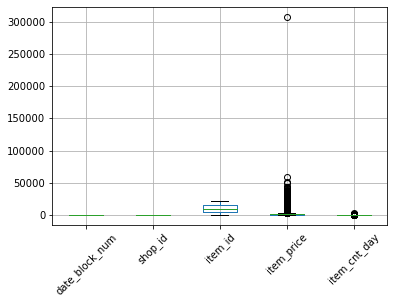

In [32]:
#Display outlier for all variables
#Visible outlier from item_price
train_df.boxplot( rot=45)

<AxesSubplot:>

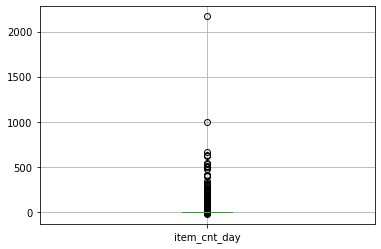

In [33]:
train_df.boxplot(column=['item_cnt_day'])


In [34]:
#Remove outlier based on boxplot
print('Data set size before remove outlier:', train_df.shape)
train_df = train_df[(train_df.item_price < 300000 )& (train_df.item_cnt_day < 1000)]
print('Data set size before remove outlier:', train_df.shape)

Data set size before remove outlier: (2935849, 6)
Data set size before remove outlier: (2935846, 6)


/Users/yogisharo/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='item_price', ylabel='Density'>

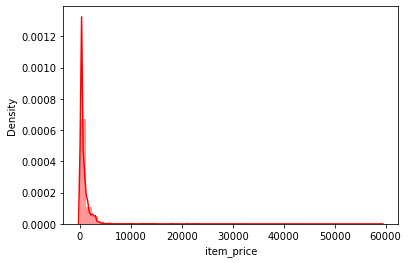

In [35]:
#Display distribution of  item count day

sns.distplot(train_df['item_price'], color = 'red')
plt.t
# train_df.item_cnt_day.hist(bins=100)
# train_df.item_cnt_day.describe()

In [36]:
#Item price should at least 1
print('Data set size before remove item price 0 cleaning:', train_df.shape)
train_df = train_df.query('item_price > 0')
print('Data set size after remove item price 0 cleaning:', train_df.shape)

Data set size before remove item price 0 cleaning: (2935846, 6)
Data set size after remove item price 0 cleaning: (2935845, 6)


In [37]:
#Display items count of day with negative numbers
train_df[train_df['item_cnt_day'] < 0].head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2,05.01.2013,0,25,2552,899.0,-1.0
148,23.01.2013,0,25,2321,999.0,-1.0
175,07.01.2013,0,25,2199,1449.0,-1.0
807,02.01.2013,0,25,2330,599.0,-1.0
1041,13.01.2013,0,25,5034,1989.0,-1.0


In [38]:
#Only get non-negative count of day value
print('Data set size before remove item price 0 cleaning:', train_df.shape)
train_df = train_df.query('item_cnt_day >= 0')
print('Data set size after remove item price 0 cleaning:', train_df.shape)

Data set size before remove item price 0 cleaning: (2935845, 6)
Data set size after remove item price 0 cleaning: (2928489, 6)


Data visualization

In [39]:
#Merge datasets (items,item_categories,shops) using Inner join
train_df_merged = pd.merge(train_df, items, on='item_id', how='inner')
train_df_merged = pd.merge(train_df_merged, item_categories, on='item_category_id', how='inner')
train_df_merged = pd.merge(train_df_merged, shops, on='shop_id', how='inner')


In [17]:
train_df_merged.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
0,02.01.2013,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
1,26.04.2013,3,59,944,150.0,1.0,2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
2,26.06.2013,5,59,944,199.5,1.0,2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
3,20.07.2013,6,59,944,199.5,1.0,2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
4,14.09.2013,8,59,944,299.0,2.0,2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""


In [18]:
#generate new features and fix date

train_df_merged['total_sales'] = train_df_merged.item_price * train_df_merged.item_cnt_day
train_df_merged['date'] = pd.to_datetime(train_df_merged.date)
train_df_merged['Month'] = train_df_merged['date'].dt.month
train_df_merged['Year'] = train_df_merged['date'].dt.year
train_df_merged['day_of_week'] = train_df_merged['date'].dt.day_name() 

In [19]:
train_df_merged.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,total_sales,Month,Year,day_of_week
0,2013-02-01,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир""",999.0,2,2013,Friday
1,2013-04-26,3,59,944,150.0,1.0,2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир""",150.0,4,2013,Friday
2,2013-06-26,5,59,944,199.5,1.0,2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир""",199.5,6,2013,Wednesday
3,2013-07-20,6,59,944,199.5,1.0,2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир""",199.5,7,2013,Saturday
4,2013-09-14,8,59,944,299.0,2.0,2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир""",598.0,9,2013,Saturday


# 3.Exploratory data analysis

In [20]:
start = time.time()

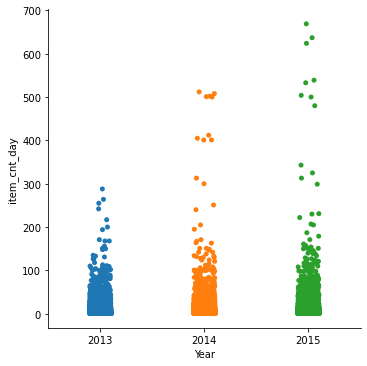

In [21]:
sns.catplot(x='Year', y='item_cnt_day', data=train_df_merged)

It tooks:  25 seconds to run


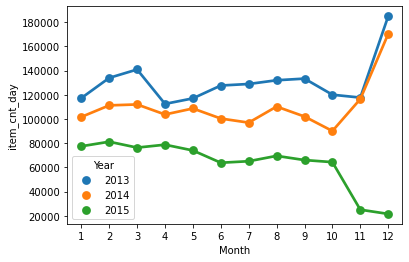

In [22]:
#Between 2013 & 2014, EoY marks the highest total item purchased. However the trend drops on 2015
grouped = pd.DataFrame(train_df_merged.groupby(['Year','Month'])['item_cnt_day'].sum().reset_index())
sns.pointplot(x='Month', y='item_cnt_day', hue='Year', data=grouped)

print('It tooks: ', round(time.time() - start), 'seconds to run')

# 4.Modelling

In [24]:
train_df_merged.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'item_name', 'item_category_id', 'item_category_name',
       'shop_name', 'total_sales', 'Month', 'Year', 'day_of_week'],
      dtype='object')

In [ ]:
y = train_df_merged.item_cnt_day
X = train_df_merged.drop(['date', 'month'], axis=1)
X.rename(columns = {'item_category_id_y' : 'item_category_id'}, inplace = True)
X.head()

In [23]:
categorical_features = ['shop_id', 'item_category_id', 'Month']
for col in categorical_features:
    train_df_merged.loc[:, col] = train_df_merged[col].astype('category')

# 4.1 Train test val split

In [ ]:
X_train, y_train, X_val, y_val, X_test = train_val_test_split(train_df_merged)

# 4.2 Model Training

In [2]:
test_df

NameError: name 'test_df' is not defined